# OKCupid Data Exploration
###### *The purpose of this project is to practice formulating questions and implementing machine learning techniques to answer those questions. This notebook contains the code and high level descriptions of the technical methods employed.*

In [2]:
#generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import and summarize dataset
profiles = pd.read_csv('/Users/domthegreat/Downloads/OKCupid-Date-A-Scientist-Starter/profiles.csv')
#print(profiles.head())
profiles.columns = profiles.columns.str.strip()
print(profiles.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

### Goal: Make two sets of classification models to classify sexual orientation. 
###### *First Model Set: Numerical and Categorical features.* 
###### *Second Model Set: NLP Model set using essay entries by users. Can the language queer and straight users put in their essay prompts be used to classify their orientation?*

In [3]:
#explore numerical variables
numerical_headers = profiles.select_dtypes(include=['int64', 'float64']).columns.tolist()
#print(numerical_headers)

for x in numerical_headers:
    describe = profiles[x].describe()
    print(f"Summary statistics for: {x}")
    print(describe)

print(f"Profiles where income=-1: {profiles[profiles.income < 1].income.value_counts()}")
print(f"Summary of filled out income: {profiles[profiles.income > 1].income.describe()}")
    
#Notes:
#Height appears to be in inches and has low value outliers
#Income appears to have '-1' for the majority of entries. A value of -1 is assumed to indicate that the user left the field blank

Summary statistics for: age
count    59946.000000
mean        32.340290
std          9.452779
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max        110.000000
Name: age, dtype: float64
Summary statistics for: height
count    59943.000000
mean        68.295281
std          3.994803
min          1.000000
25%         66.000000
50%         68.000000
75%         71.000000
max         95.000000
Name: height, dtype: float64
Summary statistics for: income
count      59946.000000
mean       20033.222534
std        97346.192104
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           -1.000000
max      1000000.000000
Name: income, dtype: float64
Profiles where income=-1: income
-1    48442
Name: count, dtype: int64
Summary of filled out income: count      11504.000000
mean      104394.993046
std       201433.528307
min        20000.000000
25%        20000.000000
50%        50000.000000
75%       100000.000000
max      1000

In [4]:
#Explore categorical variables
#number of unique values 
categorical_headers = [
    col for col in profiles.select_dtypes(include=['object']).columns
    if "essay" not in col]
print(categorical_headers)

for x in categorical_headers:
    print(f"Number of unique values for {x}: {profiles[x].nunique()}")

['body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'last_online', 'location', 'offspring', 'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks', 'status']
Number of unique values for body_type: 12
Number of unique values for diet: 18
Number of unique values for drinks: 6
Number of unique values for drugs: 3
Number of unique values for education: 32
Number of unique values for ethnicity: 217
Number of unique values for job: 21
Number of unique values for last_online: 30123
Number of unique values for location: 199
Number of unique values for offspring: 15
Number of unique values for orientation: 3
Number of unique values for pets: 15
Number of unique values for religion: 45
Number of unique values for sex: 2
Number of unique values for sign: 48
Number of unique values for smokes: 5
Number of unique values for speaks: 7647
Number of unique values for status: 5


In [5]:
#Explore categorical variables
nunqiue21_categorical_headers = [col for col in categorical_headers if profiles[col].nunique()<=21]
nunqiue22plus_categorical_headers = [col for col in categorical_headers if profiles[col].nunique()>21]

#21 or fewer categories
for x in nunqiue21_categorical_headers:
    print(f"Value counts for: {x}")
    print(profiles[x].value_counts().sort_values())

#More than 21 categries
for x in nunqiue22plus_categorical_headers:
    print(f"Sample values for: {x}")
    print(profiles[x].head(5))

Value counts for: body_type
body_type
rather not say      198
used up             355
jacked              421
overweight          444
full figured       1009
skinny             1777
a little extra     2629
curvy              3924
thin               4711
athletic          11819
fit               12711
average           14652
Name: count, dtype: int64
Value counts for: diet
diet
kosher                    11
halal                     11
strictly kosher           18
strictly halal            18
mostly halal              48
mostly kosher             86
vegan                    136
strictly vegan           228
other                    331
mostly vegan             338
strictly other           452
vegetarian               667
strictly vegetarian      875
mostly other            1007
mostly vegetarian       3444
strictly anything       5113
anything                6183
mostly anything        16585
Name: count, dtype: int64
Value counts for: drinks
drinks
desperately      322
very often       47

In [8]:
#data transformations
#get rid of age outliers
avg_age_clean = profiles.loc[profiles['age'] < 100, 'age'].mean()
profiles['age_clean'] = profiles['age'].apply(lambda a: avg_age_clean if a > 100 else a)

#orientation=Target variable. Turn into binary
profiles['orientation_clean'] = profiles['orientation'].str.replace('gay','gay_or_bi',regex=False).str.replace('bisexual','gay_or_bi',regex=False)
print(profiles.orientation_clean.value_counts())

#height: make all values below 4ft equal to the average with those values removed
#print(profiles.height.value_counts().sort_index())
height_avg_clean = profiles.loc[profiles['height'] >= 48, 'height'].mean()

# Replace invalid heights (< 48) with the clean mean
profiles['height_clean'] = profiles['height'].apply(
    lambda h: height_avg_clean if (pd.isna(h) or h < 48) else h)

#simplify diet feature
profiles['diet_clean'] = (profiles['diet'].str.lower().str.replace(r'^(strictly|mostly)\s+', '', regex=True))
#print(profiles.diet_clean.value_counts())

#simplify and split out offspring feature
profiles['offspring'] = profiles['offspring'].str.replace('&rsquo;', "'", regex=False)
# First build has_children normally
profiles['has_children'] = (profiles['offspring'].str.replace(r"^has.*", "has child(ren)", regex=True).str.replace(r"^doesn't have kids.*", "Does NOT have child(ren)", regex=True))
want_only = ["wants kids", "doesn't want kids", "might want kids"]
profiles.loc[profiles['offspring'].isin(want_only), 'has_children'] = "Not Listed"

profiles['wants_children'] = (profiles['offspring'].str.replace(r".*doesn't want.*", "Does NOT want children", regex=True).str.replace(r".*wants.*", "Wants children", regex=True).str.replace(r".*might want.*", "Might want children", regex=True))
has_only = ["has kids", "doesn't have kids", "has a kid"]
profiles.loc[profiles['offspring'].isin(has_only), 'wants_children'] = "Not Listed"
#print(profiles.has_children.value_counts())
#print(profiles.wants_children.value_counts())

#Simplify education feature
profiles['highest_education'] = profiles['education']
profiles.loc[profiles['education'].isin(['graduated from college/university','college/university']), 'highest_education'] = 'college_degree'
profiles.loc[profiles['education'].isin(['graduated from masters program','graduated from law school','graduated from ph.d program','ph.d program','law school','masters program','graduated from med school','med school']), 'highest_education'] = 'grad_degree'   
profiles.loc[profiles['education'].isin(['working on college/university','working on two-year college','two-year college','working on two-year college','graduated from two-year college','dropped out of college/university','dropped out of two-year college']), 'highest_education'] = 'some_college'
profiles.loc[profiles['education'].isin(['working on masters program','dropped out of med school','dropped out of law school','dropped out of ph.d program','dropped out of masters program','working on ph.d program','working on med school','working on med school','working on law school']), 'highest_education'] = 'some_grad'
profiles.loc[profiles['education'].isin(['high school','working on high school','dropped out of high school','graduated from high school']), 'highest_education'] = 'highschool_or_less'
profiles.loc[profiles['education'].isin(['space camp','working on space camp','dropped out of space camp','graduated from space camp']), 'highest_education'] = 'space_camp'

#print(profiles.education.value_counts())                                         
#print(profiles.highest_education.value_counts())

profiles[["religion_clean", "religion_factor"]] = profiles["religion"].str.extract(r"^(agnosticism|atheism|catholicism|buddhism|christianity|hinduism|islam|judaism|other)(.*)$")

#Clean up spacing in the factor column
profiles["religion_factor"] = profiles["religion_factor"].str.strip()
#profiles["religion_factor"] = profiles["religion_factor"].fillna("Not Listed")

#print(profiles.religion.value_counts())
#print(profiles.religion_clean.value_counts())
#print(profiles.religion_factor.value_counts())

#location --> Split into city and state
profiles['city'] = profiles['location'].str.split(',').apply(lambda x: x[0])
profiles['state'] = profiles['location'].str.split(',').apply(lambda x: x[1])
#print(profiles.city.head())
#print(profiles.state.head())

#split sign into sign and factor like religion

profiles[["sign_clean", "sign_factor"]] = profiles["sign"].str.extract(r"^(gemini|scorpio|leo|libra|taurus|cancer|pisces|virgo|aries|aquarius|capricorn|sagittarius)(.*)$")

#Clean up spacing in the factor column
profiles["sign_factor"] = profiles["sign_factor"].str.replace('and','').str.replace('but','').str.replace("it&rsquo;s","it's").str.replace('doesn&rsquo;t',"doesn't").str.strip()

#print(profiles.sign.value_counts())
#print(profiles.sign_clean.value_counts())
#print(profiles.sign_factor.value_counts())

#make speaks into a numerical column by number of languages spoken
profiles['number_of_languages'] = profiles['speaks'].apply(lambda x: max(len(str(x).split(',')), 1) if pd.notnull(x) else 1)
#print(profiles.number_of_languages.head())
#print(profiles.number_of_languages.value_counts())

#create dummy variables for race/ethnicity
ethnicity_dummies = profiles['ethnicity'].str.replace(r'\s*,\s*', ',', regex=True).str.get_dummies(sep=',')
ethnicity_dummies.columns = [c.strip() for c in ethnicity_dummies.columns]
cols_to_create = ['white','black','asian','hispanic / latin','middle eastern', 'indian','pacific islander','other','native american']
profiles = profiles.drop(columns=[c for c in cols_to_create if c in profiles.columns])
profiles = profiles.join(ethnicity_dummies)
#print(profiles.ethnicity.value_counts())
#print(profiles.info())
#print(profiles.white.describe())

#split pets into cats and dogs variables
#Below fills in 0s for null values, which may not be a fair assumption to make
profiles['likes_or_has_dogs'] = 0 #profiles['pets'].apply(lambda x: 0 if pd.isnull(x)=False else 0)
profiles['likes_or_has_cats'] = 0 #profiles['pets'].apply(lambda x: 0 if pd.isnull(x)=False else 0)
profiles['dislikes_cats'] = 0 
profiles['dislikes_dogs'] = 0 

#below is super error prone, probably a better way to do this
profiles.loc[profiles['pets'].isin(['likes dogs and likes cats','likes dogs','likes dogs and has cats','has dogs','has dogs and likes cats','has dogs and has cats','has dogs and dislikes cats']), 'likes_or_has_dogs'] = 1
profiles.loc[profiles['pets'].isin(['dislikes dogs and has cats','likes cats','has cats', 'has dogs and has cats', 'has dogs and likes cats','likes dogs and has cats','likes dogs and likes cats']), 'likes_or_has_cats'] = 1
profiles.loc[profiles['pets'].isin(['dislikes cats','has dogs and dislikes cats','dislikes dogs and dislikes cats']), 'dislikes_cats'] = 1
profiles.loc[profiles['pets'].isin(['dislikes dogs','dislikes dogs and has cats','dislikes dogs and dislikes cats']), 'dislikes_dogs'] = 1

print(profiles.info())

print(profiles.orientation_clean.value_counts())

orientation_clean
straight     51606
gay_or_bi     8340
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  59946 non-null  int64  
 1   body_type            54650 non-null  object 
 2   diet                 35551 non-null  object 
 3   drinks               56961 non-null  object 
 4   drugs                45866 non-null  object 
 5   education            53318 non-null  object 
 6   essay0               54458 non-null  object 
 7   essay1               52374 non-null  object 
 8   essay2               50308 non-null  object 
 9   essay3               48470 non-null  object 
 10  essay4               49409 non-null  object 
 11  essay5               49096 non-null  object 
 12  essay6               46175 non-null  object 
 13  essay7               47495 non-null  object 
 14  essa

In [9]:
#Prep final numerical feature dataframe
#replace NAs with 'Not Listed' category
profiles_clean_num = profiles[['age_clean','body_type','drinks','drugs','job','sex','smokes',
                           'status', 'height_clean', 'diet_clean', 'has_children','wants_children',
                           'orientation_clean','highest_education','religion_clean','religion_factor',
                           'sign_clean','sign_factor','number_of_languages','asian','black','hispanic / latin',
                           'indian', 'middle eastern','native american', 'other','pacific islander','white',
                           'likes_or_has_dogs','likes_or_has_cats','dislikes_cats','dislikes_dogs']]

# Remove and encode label variable
label_col = "orientation_clean"
y = profiles_clean_num[label_col]       # keep raw labels (still strings or categories)
profiles_clean_num = profiles_clean_num.drop(columns=[label_col])

from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()
#y_encoded = le.fit_transform()

mapping = {"straight": 0, "gay_or_bi": 1}
y = y.map(mapping)

# Fill nulls in categorical columns with "Not Listed"
profiles_clean_num = profiles_clean_num.fillna(
    {col: "Not_Listed" for col in profiles_clean_num.select_dtypes(include="object").columns}
)

categorical_cols = profiles_clean_num.select_dtypes(include="object").columns

# Make dummy variables
X = pd.get_dummies(profiles_clean_num, columns=categorical_cols, prefix_sep="_")

# Figure out which dummy columns to drop
cols_to_drop = []

for col in categorical_cols:
    if "Not_Listed" in profiles_clean_num[col].values:  
        # if "Not Listed" actually appeared in this column → drop that dummy
        cols_to_drop.append(f"{col}_Not_Listed")
    else:
        # otherwise drop the first dummy (alphabetical order of unique categories)
        first_cat = sorted(profiles_clean_num[col].unique())[0]
        cols_to_drop.append(f"{col}_{first_cat}")

# Clean column names
X.columns = (
    X.columns
    .str.replace(' ', '_', regex=False)
    .str.replace('/', '', regex=False)
)


# Drop chosen columns
X = X.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
#print(profiles_clean_num_final.head())
print(X.columns)
print(y)

Dropped columns: ['body_type_Not_Listed', 'drinks_Not_Listed', 'drugs_Not_Listed', 'job_Not_Listed', 'sex_f', 'smokes_Not_Listed', 'status_available', 'diet_clean_Not_Listed', 'has_children_Not_Listed', 'wants_children_Not_Listed', 'highest_education_Not_Listed', 'religion_clean_Not_Listed', 'religion_factor_Not_Listed', 'sign_clean_Not_Listed', 'sign_factor_Not_Listed']
Index(['age_clean', 'height_clean', 'number_of_languages', 'asian', 'black',
       'hispanic__latin', 'indian', 'middle_eastern', 'native_american',
       'other',
       ...
       'sign_clean_libra', 'sign_clean_pisces', 'sign_clean_sagittarius',
       'sign_clean_scorpio', 'sign_clean_taurus', 'sign_clean_virgo',
       'sign_factor_', 'sign_factor_it_doesn't_matter',
       'sign_factor_it_matters_a_lot', 'sign_factor_it's_fun_to_think_about'],
      dtype='object', length=115)
0        0
1        0
2        0
3        0
4        0
        ..
59941    0
59942    0
59943    0
59944    0
59945    1
Name: orientati

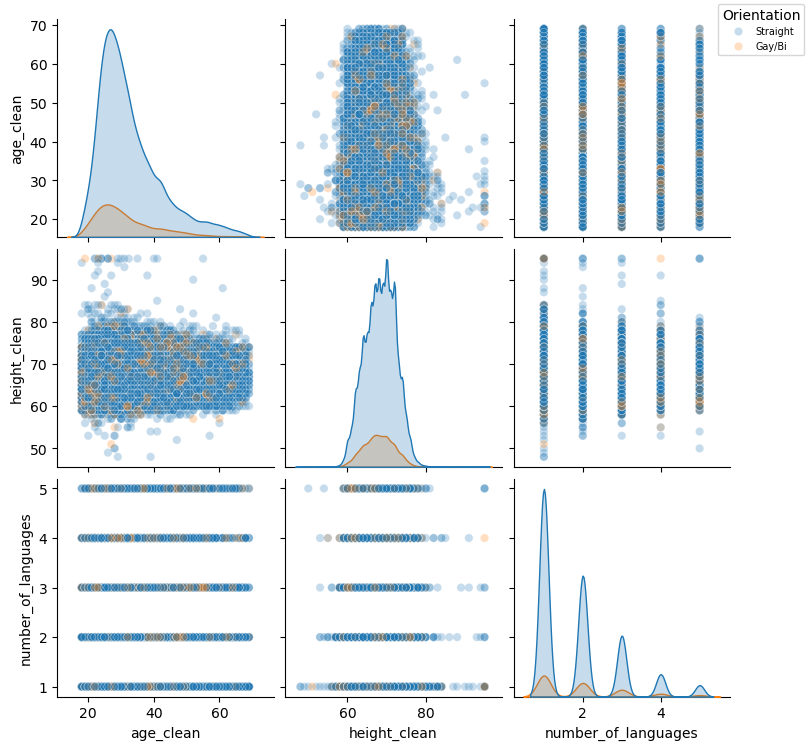

<Figure size 640x480 with 0 Axes>

In [10]:
#visualizations of relationships between label and select features
#continuous variables 
df_plot = X[["age_clean", "height_clean", "number_of_languages"]].copy()
df_plot["target"] = y

g = sns.pairplot(
    df_plot,
    vars=["age_clean", "height_clean", "number_of_languages"],
    hue="target",
    plot_kws={'alpha': 0.25}
)

# Get current legend handles and labels
handles = g._legend_data.values()
labels = ['Straight', 'Gay/Bi']   # match the order of your hue levels

# Replace the legend
g._legend.remove()  # remove default
g.fig.legend( handles=handles, labels=labels,fontsize="x-small", loc="outside right upper", title="Orientation")
plt.savefig("/Users/domthegreat/Desktop/my_plot6.png", dpi=300)
plt.show()
plt.clf()

                                      pct_not_straight  count
status_available                              0.371582   1865
diet_clean_vegan                              0.307692    702
sign_factor_it_matters_a_lot                  0.281481    675
status_seeing_someone                         0.278101   2064
status_married                                0.274194    310
wants_children_Does_NOT_want_children         0.247069   4776
job_unemployed                                0.238095    273
diet_clean_kosher                             0.226087    115
smokes_yes                                     0.21784   2231
drugs_often                                   0.212195    410
native_american                               0.211858   1265
religion_clean_buddhism                       0.209959   1948
body_type_full_figured                        0.208127   1009
drugs_sometimes                                0.20732   7732
body_type_skinny                              0.203714   1777
job_stud

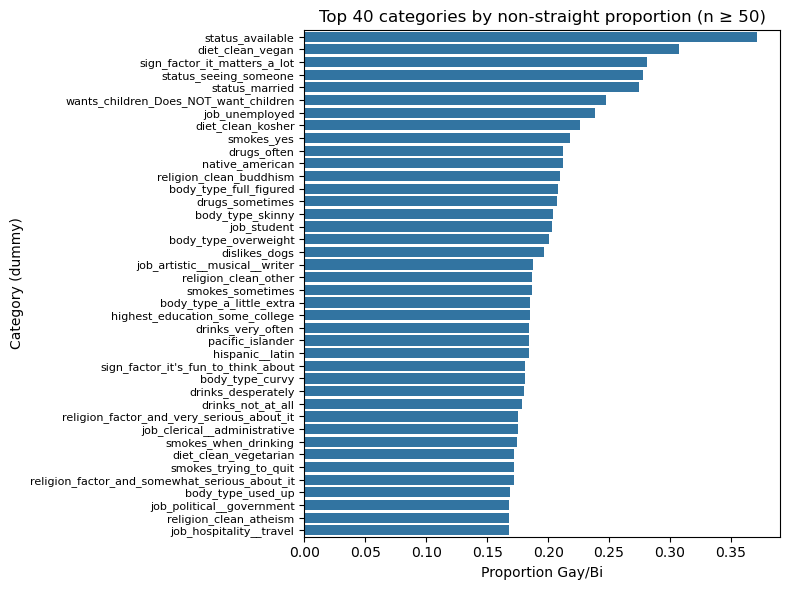

<Figure size 640x480 with 0 Axes>

In [32]:
#now look at the categories
# === VIZ BRANCH: use all categories, separate from ML ===
profiles_viz = profiles[['age_clean','body_type','drinks','drugs','job','sex','smokes',
                         'status', 'height_clean', 'diet_clean','has_children','wants_children',
                         'orientation_clean','highest_education','religion_clean','religion_factor',
                         'sign_clean','sign_factor','number_of_languages','asian','black','hispanic / latin',
                         'indian','middle eastern','native american','other','pacific islander','white',
                         'likes_or_has_dogs','likes_or_has_cats','dislikes_cats','dislikes_dogs']].copy()

# label for viz (same mapping)
y_viz = profiles_viz["orientation_clean"].map({"straight": 0, "gay_or_bi": 1})

# drop label from features for dummy-creation
profiles_viz = profiles_viz.drop(columns=["orientation_clean"])

# Fill NAs in categoricals
profiles_viz = profiles_viz.fillna(
    {col: "Not_Listed" for col in profiles_viz.select_dtypes(include="object").columns}
)

categorical_cols_viz = profiles_viz.select_dtypes(include="object").columns

# IMPORTANT: don't drop any levels here (no reference removal)
X_viz = pd.get_dummies(profiles_viz, columns=categorical_cols_viz, prefix_sep="_", drop_first=False)

# Clean names in the same way (for pretty plotting)
X_viz.columns = (
    X_viz.columns
    .str.replace(' ', '_', regex=False)
    .str.replace('/', '', regex=False)
)

# Only dummy columns (0/1); we can assume all non-numeric dummies in X_viz except raw numerics
dummy_cols_viz = []

for c in X_viz.columns:
    col_data = X_viz[c]

    # If we somehow got a DataFrame (duplicate column names), skip for now or handle differently
    if isinstance(col_data, pd.DataFrame):
        continue  # or print a warning to inspect duplicates

    # True dummy columns: only 0/1 (ignoring NaNs)
    if col_data.dropna().isin([0, 1]).all():
        dummy_cols_viz.append(c)

# Count how many users fall in each category
counts = X_viz[dummy_cols_viz].sum(axis=0)

# Sum of target within each category
sum_targets = (X_viz[dummy_cols_viz].T @ y_viz)  # matrix multiply

prop_not_straight = (sum_targets / counts).rename("pct_not_straight")

prop_df = pd.concat([prop_not_straight, counts.rename("count")], axis=1)
prop_df = prop_df.sort_values("pct_not_straight", ascending=False)

print(prop_df.head(20))


MIN_N = 50  # optional: filter out tiny categories
topN = 40

plot_df = prop_df[prop_df["count"] >= MIN_N].head(topN).reset_index()
plot_df.rename(columns={"index": "category"}, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=plot_df,
    y="category",
    x="pct_not_straight"
)
plt.xlabel("Proportion Gay/Bi")
plt.ylabel("Category (dummy)")
plt.yticks(fontsize=8)
plt.title(f"Top {topN} categories by non-straight proportion (n ≥ {MIN_N})")
plt.tight_layout()
plt.savefig("/Users/domthegreat/Desktop/my_plot6.png", dpi=300)
plt.show()
plt.clf()

In [33]:
#Create evaluation output function
def model_performance(best_model, y_test, y_pred):
    print("📊 Model Evaluation Results:\n")
    # Accuracy
    print("Accuracy (overall correctness of predictions):", accuracy_score(y_test, y_pred))
    # Precision
    print("Precision (out of all predicted positives, how many were correct):", 
          precision_score(y_test, y_pred, average="binary"))
    # Recall
    print("Recall (out of all actual positives, how many did we correctly identify):", 
          recall_score(y_test, y_pred, average="binary"))
    # F1 Score
    print("F1 Score (harmonic mean of precision and recall):", 
          f1_score(y_test, y_pred, average="binary"))
    # Confusion Matrix
    print("\nConfusion Matrix (rows = actual, cols = predicted):\n", confusion_matrix(y_test, y_pred))
    # Classification Report
    print("\nClassification Report (precision, recall, f1-score per class):\n")
    print(classification_report(y_test, y_pred))
    y_pred_probs = best_model.predict_proba(X_test)[:,1]
    thresholds = np.linspace(0, 1, 101)
    
    recalls = []
    accuracies = []
    precisions = []
    f1s = []
    
    #plot the metrics against threhold levels
    for t in thresholds:
        y_pred_custom = (y_pred_probs >= t).astype(int)
        recalls.append(recall_score(y_test, y_pred_custom))
        accuracies.append(accuracy_score(y_test, y_pred_custom))
        precisions.append(precision_score(y_test, y_pred_custom, zero_division=0))
        f1s.append(f1_score(y_test, y_pred_custom, zero_division=0))
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, recalls, label="Recall", color="red")
    plt.plot(thresholds, accuracies, label="Accuracy", color="blue")
    plt.plot(thresholds, precisions, label="Precision", color="orange")
    plt.plot(thresholds, f1s, label="F1", color="green")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Recall, Accuracy, and Precision vs. Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.clf()

Best params: {'n_estimators': 200, 'max_features': 0.25, 'max_depth': 30}
📊 Model Evaluation Results:

Accuracy (overall correctness of predictions): 0.8632193494578816
Precision (out of all predicted positives, how many were correct): 0.6102941176470589
Recall (out of all actual positives, how many did we correctly identify): 0.04970059880239521
F1 Score (harmonic mean of precision and recall): 0.09191583610188261

Confusion Matrix (rows = actual, cols = predicted):
 [[10267    53]
 [ 1587    83]]

Classification Report (precision, recall, f1-score per class):

              precision    recall  f1-score   support

           0       0.87      0.99      0.93     10320
           1       0.61      0.05      0.09      1670

    accuracy                           0.86     11990
   macro avg       0.74      0.52      0.51     11990
weighted avg       0.83      0.86      0.81     11990



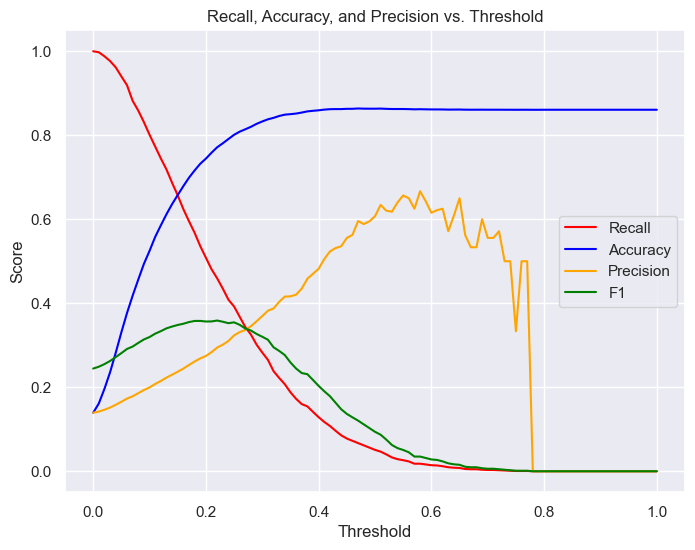

'\nprint("📊 Model Evaluation Results:\n")\n\n# Accuracy\nprint("Accuracy (overall correctness of predictions):", accuracy_score(y_test, y_pred))\n\n# Precision\nprint("Precision (out of all predicted positives, how many were correct):", \n      precision_score(y_test, y_pred, average="binary"))\n\n# Recall\nprint("Recall (out of all actual positives, how many did we correctly identify):", \n      recall_score(y_test, y_pred, average="binary"))\n\n# F1 Score\nprint("F1 Score (harmonic mean of precision and recall):", \n      f1_score(y_test, y_pred, average="binary"))\n\n# Confusion Matrix\nprint("\nConfusion Matrix (rows = actual, cols = predicted):\n", confusion_matrix(y_test, y_pred))\n\n# Classification Report\nprint("\nClassification Report (precision, recall, f1-score per class):\n")\nprint(classification_report(y_test, y_pred))\n\n'

<Figure size 1000x1200 with 0 Axes>

In [297]:
#model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


#Random forest
gay_forest = RandomForestClassifier(random_state = 16)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, 30],
    'max_features': ['sqrt', 'log2', 10, .25]
    #'min_samples_leaf': [1, 2, 5]
}

gay_grid = RandomizedSearchCV(
        gay_forest,
        param_distributions = param_dist,
        n_iter = 50,
        cv=5,
        n_jobs=1
)

gay_grid.fit(X_train, y_train)

print("Best params:", gay_grid.best_params_)
best_gay_forest = gay_grid.best_estimator_

y_pred = best_gay_forest.predict(X_test)

#plot performance
model_performance(best_model=best_gay_forest,y_test=y_test,y_pred=y_pred)

Best params: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5}
📊 Model Evaluation Results:

Accuracy (overall correctness of predictions): 0.6832360300250209
Precision (out of all predicted positives, how many were correct): 0.23908778813143697
Recall (out of all actual positives, how many did we correctly identify): 0.5838323353293413
F1 Score (harmonic mean of precision and recall): 0.33924843423799583

Confusion Matrix (rows = actual, cols = predicted):
 [[7217 3103]
 [ 695  975]]

Classification Report (precision, recall, f1-score per class):

              precision    recall  f1-score   support

           0       0.91      0.70      0.79     10320
           1       0.24      0.58      0.34      1670

    accuracy                           0.68     11990
   macro avg       0.58      0.64      0.57     11990
weighted avg       0.82      0.68      0.73     11990



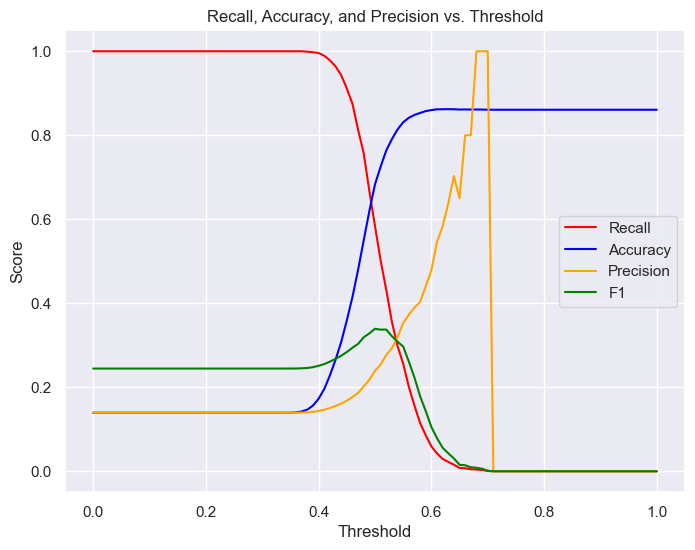

'\n#plot performance\nmodel_performance(best_model=best_gay_forest,y_test=y_test,y_pred=y_pred)\nprint("📊 Model Evaluation Results:\n")\n\n# Accuracy\nprint("Accuracy (overall correctness of predictions):", accuracy_score(y_test, y_pred))\n\n# Precision\nprint("Precision (out of all predicted positives, how many were correct):", \n      precision_score(y_test, y_pred, average="binary"))\n\n# Recall\nprint("Recall (out of all actual positives, how many did we correctly identify):", \n      recall_score(y_test, y_pred, average="binary"))\n\n# F1 Score\nprint("F1 Score (harmonic mean of precision and recall):", \n      f1_score(y_test, y_pred, average="binary"))\n\n# Confusion Matrix\nprint("\nConfusion Matrix (rows = actual, cols = predicted):\n", confusion_matrix(y_test, y_pred))\n\n# Classification Report\nprint("\nClassification Report (precision, recall, f1-score per class):\n")\nprint(classification_report(y_test, y_pred))\n\ny_pred_probs = best_gay_forest.predict_proba(X_test)[:,1]

<Figure size 1000x1200 with 0 Axes>

In [299]:
#Try again but boost recall
#Random forest

#BALANCE the class weights
gay_forest = RandomForestClassifier(class_weight = 'balanced', random_state = 16)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, 30],
    'max_features': ['sqrt', 'log2', 10, .25]
    #'min_samples_leaf': [1, 2, 5]
}

#Optimize for RECALL vs accuracy
gay_grid = RandomizedSearchCV(
        gay_forest,
        param_distributions = param_dist,
        n_iter = 50,
        scoring = "recall", 
        cv=5,
        n_jobs=-1
)

gay_grid.fit(X_train, y_train)

print("Best params:", gay_grid.best_params_)
best_gay_forest = gay_grid.best_estimator_

y_pred = best_gay_forest.predict(X_test)

#plot performance
model_performance(best_model=best_gay_forest,y_test=y_test,y_pred=y_pred)

📊 Model Evaluation Results:

Accuracy (overall correctness of predictions): 0.6231859883236031
Precision (out of all predicted positives, how many were correct): 0.1510544384502207
Recall (out of all actual positives, how many did we correctly identify): 0.3684210526315789
F1 Score (harmonic mean of precision and recall): 0.2142608695652174

Confusion Matrix (rows = actual, cols = predicted):
 [[6856 3462]
 [1056  616]]

Classification Report (precision, recall, f1-score per class):

              precision    recall  f1-score   support

           0       0.87      0.66      0.75     10318
           1       0.15      0.37      0.21      1672

    accuracy                           0.62     11990
   macro avg       0.51      0.52      0.48     11990
weighted avg       0.77      0.62      0.68     11990



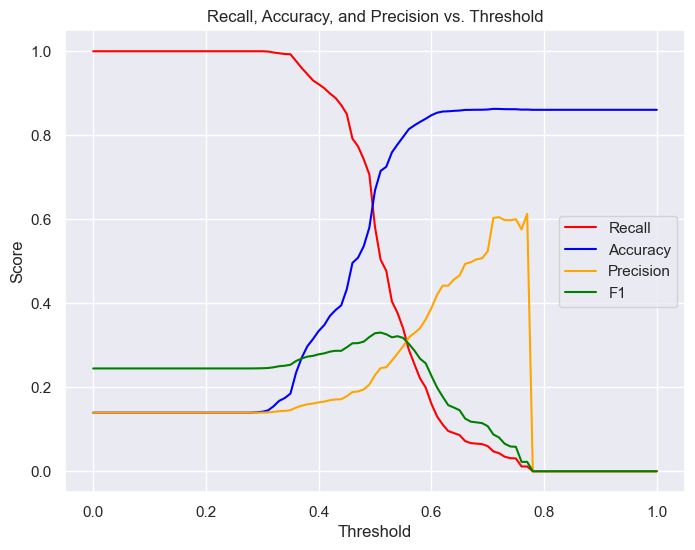

'\nprint("Best parameters:", boosted_gay_grid.best_params_)\nprint("Best score:", boosted_gay_grid.best_score_)\n\nbest_boosted_gay_forest = boosted_gay_grid.best_estimator_\n\ny_pred = best_boosted_gay_forest.predict(X_test)\n\nprint("📊 Model Evaluation Results:\n")\n\n# Accuracy\nprint("Accuracy (overall correctness of predictions):", accuracy_score(y_test, y_pred))\n\n# Precision\nprint("Precision (out of all predicted positives, how many were correct):", \n      precision_score(y_test, y_pred, average="binary"))\n\n# Recall\nprint("Recall (out of all actual positives, how many did we correctly identify):", \n      recall_score(y_test, y_pred, average="binary"))\n\n# F1 Score\nprint("F1 Score (harmonic mean of precision and recall):", \n      f1_score(y_test, y_pred, average="binary"))\n\n# Confusion Matrix\nprint("\nConfusion Matrix (rows = actual, cols = predicted):\n", confusion_matrix(y_test, y_pred))\n\n# Classification Report\nprint("\nClassification Report (precision, recall,

<Figure size 1000x1200 with 0 Axes>

In [300]:
'''
# Total count of NaNs in the whole dataset
print(X_train.isna().sum().sum())

# NaNs per column
print(X_train.isna().sum().sort_values(ascending=False).head(20))

nan_rows = X_train[X_train.isna().any(axis=1)]
print(nan_rows.head())

'''

#Had to redo the split to get rid of the two missing height values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#One more time with Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

weights = compute_sample_weight(class_weight="balanced", y=y_train)

gay_boost = GradientBoostingClassifier( random_state=16)

param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15, 20]
}

boosted_gay_grid = RandomizedSearchCV(
    estimator = gay_boost,
    param_distributions = param_dist,
    scoring = "recall",
    cv = 5,
    n_jobs = -1,
)

boosted_gay_grid.fit(X_train, y_train, sample_weight=weights)

#plot performance
model_performance(best_model=boosted_gay_grid,y_test=y_test,y_pred=y_pred)

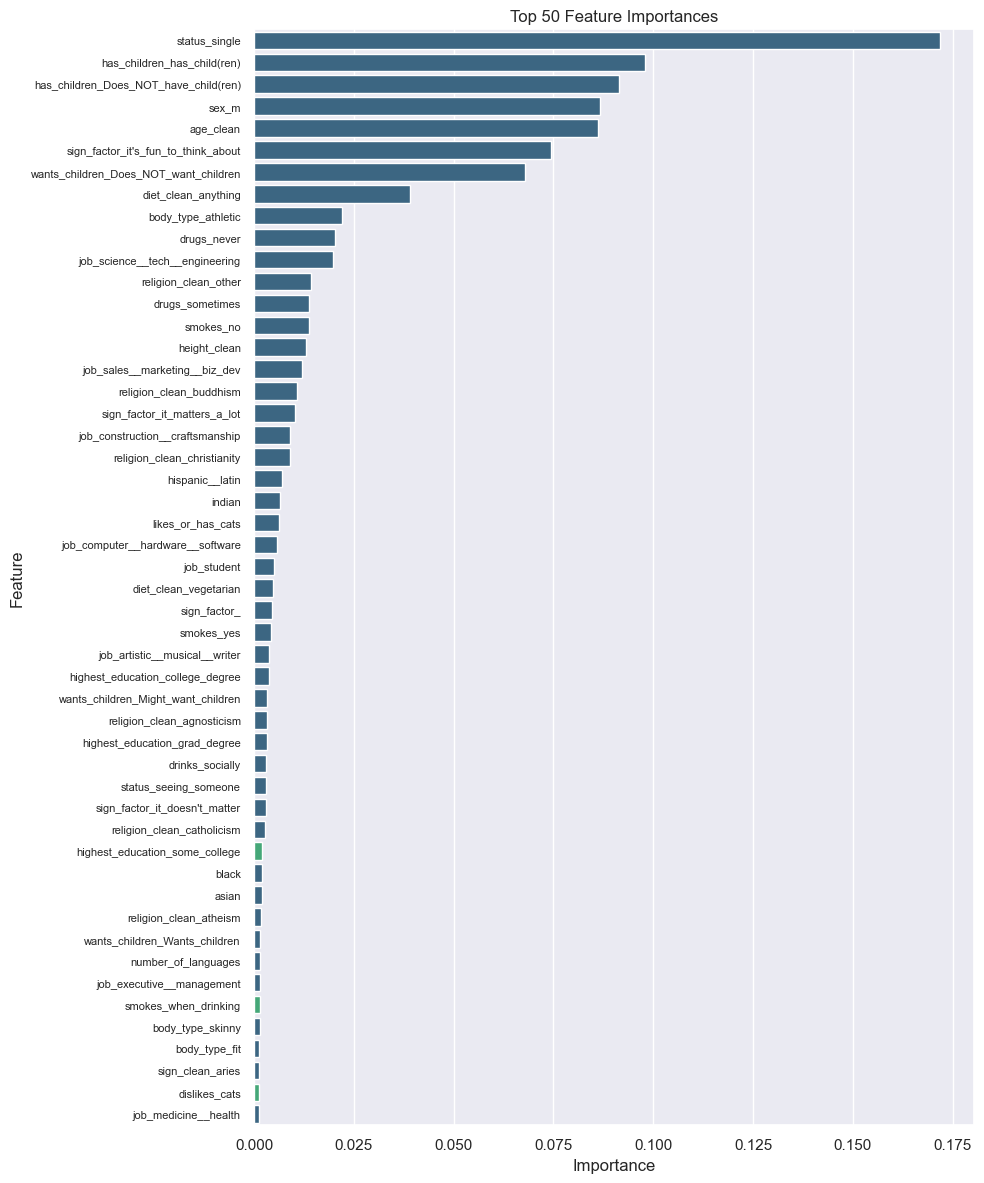

<Figure size 1000x1200 with 0 Axes>

In [267]:
#Display feature importances
feature_importances = best_boosted_gay_forest.feature_importances_

# Create a bar plot of the feature importances
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Wrap in a DataFrame for easier plotting
importance_df = pd.DataFrame({
    "Feature": sorted_feature_names,
    "Importance": sorted_importances
})

top_features = importance_df.head(50)

sns.set(rc={'figure.figsize':(10,12)})
sns.barplot(data=top_features, x="Importance", y="Feature", hue=y, legend=False, palette="viridis")
plt.yticks(fontsize=8)
plt.title("Top 50 Feature Importances")
plt.tight_layout()
plt.show()
plt.clf()

In [286]:
# On to NLP and Naive Bayes
#Preview essay content
#print(profiles.essay7[10000])
from sklearn.feature_extraction.text import CountVectorizer

# Combine essay fields into one column of text
essay_cols = [f"essay{i}" for i in range(10)]
profiles['all_essays'] = profiles[essay_cols].fillna("").agg(" ".join, axis=1)

# Example: first row's text
#print(profiles['all_essays'].iloc[0][:500])  # preview first 500 chars

counter = CountVectorizer(stop_words="english", max_features=5000)
X_text = counter.fit_transform(profiles['all_essays'])

#make the models, no CV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.25, random_state=16)

gay_nb = MultinomialNB()
gay_nb.fit(X_train, y_train)

y_pred = gay_nb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.91      0.90     12887
           1       0.40      0.37      0.38      2100

    accuracy                           0.84     14987
   macro avg       0.65      0.64      0.64     14987
weighted avg       0.83      0.84      0.83     14987



Best params: {'fit_prior': False, 'alpha': 0.01}
Best score: 0.608877318097708
📊 Model Evaluation Results:

Accuracy (overall correctness of predictions): 0.657464553794829
Precision (out of all predicted positives, how many were correct): 0.2247343432059688
Recall (out of all actual positives, how many did we correctly identify): 0.5944976076555024
F1 Score (harmonic mean of precision and recall): 0.32616899097621

Confusion Matrix (rows = actual, cols = predicted):
 [[6889 3429]
 [ 678  994]]

Classification Report (precision, recall, f1-score per class):

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10318
           1       0.22      0.59      0.33      1672

    accuracy                           0.66     11990
   macro avg       0.57      0.63      0.55     11990
weighted avg       0.81      0.66      0.71     11990



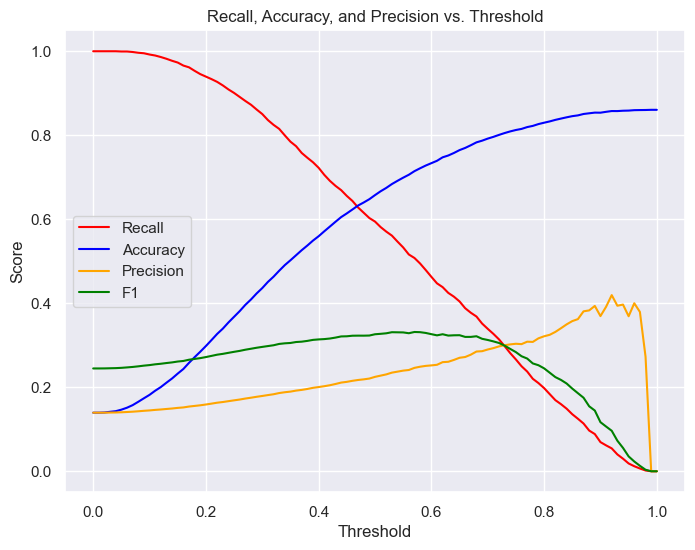

'\nprint("📊 Model Evaluation Results:\n")\n\n# Accuracy\nprint("Accuracy (overall correctness of predictions):", accuracy_score(y_test, y_pred))\n\n# Precision\nprint("Precision (out of all predicted positives, how many were correct):", \n      precision_score(y_test, y_pred, average="binary"))\n\n# Recall\nprint("Recall (out of all actual positives, how many did we correctly identify):", \n      recall_score(y_test, y_pred, average="binary"))\n\n# F1 Score\nprint("F1 Score (harmonic mean of precision and recall):", \n      f1_score(y_test, y_pred, average="binary"))\n\n# Confusion Matrix\nprint("\nConfusion Matrix (rows = actual, cols = predicted):\n", confusion_matrix(y_test, y_pred))\n\n# Classification Report\nprint("\nClassification Report (precision, recall, f1-score per class):\n")\nprint(classification_report(y_test, y_pred))\n\ny_pred_probs = best_gay_nb.predict_proba(X_test)[:,1]\nthresholds = np.linspace(0, 1, 101)\n\nrecalls = []\naccuracies = []\nprecisions = []\n\n#plot t

<Figure size 1000x1200 with 0 Axes>

In [301]:
#Go again with randomized search cv
param_dist = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

gay_grid_nb = MultinomialNB()

random_gay_grid_nb = RandomizedSearchCV(
    gay_grid_nb,
    param_dist,
    scoring='recall',
    cv=10,
    n_jobs=-1
)

random_gay_grid_nb.fit(X_train, y_train)

print("Best params:", random_gay_grid_nb.best_params_)
print("Best score:", random_gay_grid_nb.best_score_)

best_gay_nb = random_gay_grid_nb.best_estimator_

y_pred = best_gay_nb.predict(X_test)

#plot performance
model_performance(best_model=best_gay_nb,y_test=y_test,y_pred=y_pred)


Best params: {'fit_prior': True, 'alpha': 0.01}
Best score: 0.6540064102564103
📊 Model Evaluation Results:

Accuracy (overall correctness of predictions): 0.7548542069793821
Precision (out of all predicted positives, how many were correct): 0.3186635944700461
Recall (out of all actual positives, how many did we correctly identify): 0.6585714285714286
F1 Score (harmonic mean of precision and recall): 0.4295031055900621

Confusion Matrix (rows = actual, cols = predicted):
 [[9930 2957]
 [ 717 1383]]

Classification Report (precision, recall, f1-score per class):

              precision    recall  f1-score   support

           0       0.93      0.77      0.84     12887
           1       0.32      0.66      0.43      2100

    accuracy                           0.75     14987
   macro avg       0.63      0.71      0.64     14987
weighted avg       0.85      0.75      0.79     14987



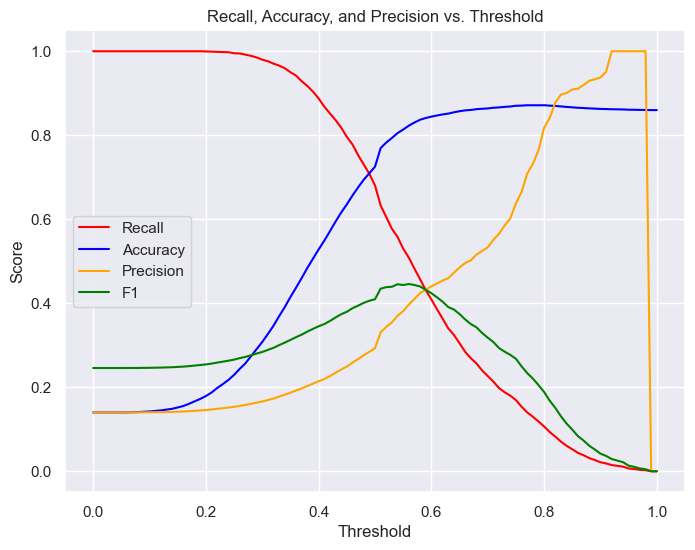

'\nprint("📊 Model Evaluation Results:\n")\n\n# Accuracy\nprint("Accuracy (overall correctness of predictions):", accuracy_score(y_test, y_pred))\n\n# Precision\nprint("Precision (out of all predicted positives, how many were correct):", \n      precision_score(y_test, y_pred, average="binary"))\n\n# Recall\nprint("Recall (out of all actual positives, how many did we correctly identify):", \n      recall_score(y_test, y_pred, average="binary"))\n\n# F1 Score\nprint("F1 Score (harmonic mean of precision and recall):", \n      f1_score(y_test, y_pred, average="binary"))\n\n# Confusion Matrix\nprint("\nConfusion Matrix (rows = actual, cols = predicted):\n", confusion_matrix(y_test, y_pred))\n\n# Classification Report\nprint("\nClassification Report (precision, recall, f1-score per class):\n")\nprint(classification_report(y_test, y_pred))\n\ny_pred_probs = best_gay_nb.predict_proba(X_test)[:,1]\nthresholds = np.linspace(0, 1, 101)\n\nrecalls = []\naccuracies = []\nprecisions = []\n\n#plot t

<Figure size 1000x1200 with 0 Axes>

In [304]:
#repeat but use TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, smooth_idf=True)
X_text = vectorizer.fit_transform(profiles['all_essays'])

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.25, random_state=16)

param_dist = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

#Try with complement NB!
from sklearn.naive_bayes import ComplementNB
gay_grid_nb = ComplementNB()

random_gay_grid_nb = RandomizedSearchCV(
    gay_grid_nb,
    param_dist,
    scoring='recall',
    cv=10,
    n_jobs=-1
)

random_gay_grid_nb.fit(X_train, y_train)

print("Best params:", random_gay_grid_nb.best_params_)
print("Best score:", random_gay_grid_nb.best_score_)

best_gay_nb = random_gay_grid_nb.best_estimator_

y_pred = best_gay_nb.predict(X_test)

#plot performance
model_performance(best_model=random_gay_grid_nb,y_test=y_test,y_pred=y_pred)


In [ ]:
#Third step: combine the numerical and text data to build one last set of classifiers 

#scale continuous variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X)
X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns, index=X_num.index)

#Same code used in ComplementNB model
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, smooth_idf=True)
X_text = vectorizer.fit_transform(profiles['all_essays'])

#combine
from scipy.sparse import hstack

X_combined = hstack([X_text, X_num_scaled])

#Make new split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=16)


Best params: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'class_weight': 'balanced', 'C': 1}
Best score: 0.6713141025641025
📊 Model Evaluation Results:

Accuracy (overall correctness of predictions): 0.7873490358310535
Precision (out of all predicted positives, how many were correct): 0.3620908398883532
Recall (out of all actual positives, how many did we correctly identify): 0.6795238095238095
F1 Score (harmonic mean of precision and recall): 0.47243833802350604

Confusion Matrix (rows = actual, cols = predicted):
 [[10373  2514]
 [  673  1427]]

Classification Report (precision, recall, f1-score per class):

              precision    recall  f1-score   support

           0       0.94      0.80      0.87     12887
           1       0.36      0.68      0.47      2100

    accuracy                           0.79     14987
   macro avg       0.65      0.74      0.67     14987
weighted avg       0.86      0.79      0.81     14987



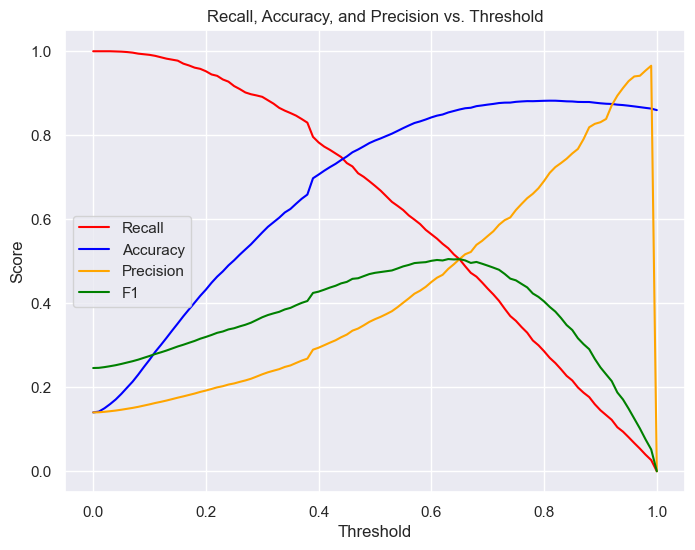

<Figure size 1000x1200 with 0 Axes>

In [306]:
#Run Logistic w/ Random CV
gay_log = LogisticRegression() 

param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [500, 1000]
}

random_gay_log = RandomizedSearchCV(
    gay_log,
    param_dist,
    n_iter = 30,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

random_gay_log.fit(X_train, y_train)

print("Best params:", random_gay_log.best_params_)
print("Best score:", random_gay_log.best_score_)

best_gay_log = random_gay_log.best_estimator_

y_pred = best_gay_log.predict(X_test)

#plot performance
model_performance(best_model=best_gay_log,y_test=y_test,y_pred=y_pred)